In [1]:
import numpy as np
import pandas as pd

import math
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from allennlp.modules.elmo import Elmo, batch_to_ids

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel('review.xlsx')
data.drop(['Unnamed: 13'], axis=1, inplace=True)
data.head()

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y
3,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Equipment,"""211.63""","Equipment design, size, and location.","Equipment used in the manufacture, processing,...",1,0.742327,C.02.005,Drugs,Good Manufacturing Practices,Equipment,The equipment with which a lot or batch of a d...,Y
4,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Records and Reports,"""211.182""",Equipment cleaning and use log.,"A written record of major equipment cleaning, ...",1,0.628404,C.02.007,Drugs,Good Manufacturing Practices,Sanitation,(1) Every person who fabricates or packages/la...,Y


In [3]:
data['fda_desc_cleaned']=''
data['hc_desc_cleaned']=''

# Pre-processing FDA Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['FDA_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within () and []
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['fda_desc_cleaned'][i] = sent_ref
        
# Pre-processing Health Canada Descriptions
lemmatizer = WordNetLemmatizer()
pattern1 = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
pattern2 = '[0-9]'
for i in range(0,len(data)):
        sent_ref = data.iloc[i]['HC_Description']
#         sent_ref = sent_ref.lower() # convert to lower case
        word_list = nltk.word_tokenize(sent_ref)
        sent_ref = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # lemmatize
        sent_ref = re.sub(r'\([^)]*\)', '', sent_ref) # remove characters which are within parenthesis
        sent_ref = pattern1.sub('', sent_ref) # remove stopwords
        sent_ref = re.sub(r'[^\w\s]','',sent_ref) # remove spaces (new line, tabs etc)
        sent_ref = re.sub(pattern2, '', sent_ref) # remove numbers
        sent_ref = " ".join(sent_ref.split()) # remove whitespaces, if any
        data['hc_desc_cleaned'][i] = sent_ref

In [4]:
def angular_distance(src, tgt):
    cos_sim = cosine_similarity(src, tgt)
    np.fill_diagonal(cos_sim, 1)
    distance = 1 - (np.arccos(cos_sim) / math.pi)
    return distance

def cosine_sim(src, tgt):
    similarity = cosine_similarity(src, tgt)
    return similarity


def manhattan_dist(src, tgt):
    distance = manhattan_distances(src, tgt)
    return distance


def euclidean_dist(src, tgt):
    distance = euclidean_distances(src, tgt)
    return distance

def vector_summation(sentences):
    sent_len = sentences.shape[1]
    summed_sentence = sentences.sum(axis=1) / sent_len
    return summed_sentence

In [5]:
def theta(src, tgt):
    similarity_ = cosine_sim(src, tgt)
    np.fill_diagonal(similarity_, 1)
    theta_ = np.arccos(similarity_) + math.radians(10)
    return theta_


def magnitude_difference(src, tgt):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    difference_ = np.abs(src_norm - tgt_norm)
    return difference_


def triangle_area_similarity(src, tgt, theta_):
    src_len = len(src)
    src_norm = norm(src, axis=1).repeat(src_len).reshape(src_len, -1)
    tgt_norm = norm(tgt, axis=1)
    triangle_similarity_ = (src_norm * tgt_norm * np.sin(theta_)) / 2
    return triangle_similarity_


def sector_area_similarity(src, tgt, theta_):
    distance_ = euclidean_dist(src, tgt)
    difference_ = magnitude_difference(src, tgt)
    sector_similarity_ = math.pi * ((distance_ + difference_) ** 2)
    sector_similarity_ *= theta_ / 360
    return sector_similarity_


def triangle_sector_similarity(src, tgt):
    theta_ = theta(src, tgt)
    triangle_similarity_ = triangle_area_similarity(src, tgt, theta_)
    sector_similarity_ = sector_area_similarity(src, tgt, theta_)
    ts_ss_ = triangle_similarity_ * sector_similarity_
    return ts_ss_

In [6]:
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

In [7]:
nlp = English()
tokenizer = Tokenizer(nlp.vocab)
elmo = Elmo(options_file, weight_file, 1, dropout=0)

In [8]:
data['angular_distance'] = ''
data['cosine']=''
data['manhattan_distance']=''
data['euclidean_distance']=''
data['tss']=''

In [9]:
for i in range(0,len(data)):
    sent1 = data['fda_desc_cleaned'][i]
    sent2 = data['hc_desc_cleaned'][i]
    sentences = [sent1,sent2]
    sentences = [[tok.text for tok in tokenizer(sentence)] for sentence in sentences]
    char_ids = batch_to_ids(sentences)
    embedding_tensor = elmo(char_ids)["elmo_representations"][0]
    embedding_array = embedding_tensor.detach().numpy()
    enc_sentences = vector_summation(embedding_array)
    
    data['angular_distance'][i] = angular_distance(enc_sentences[0:1],enc_sentences)[0,1]
    data['cosine'][i] = cosine_sim(enc_sentences[0:1],enc_sentences)[0,1]
    data['manhattan_distance'][i] = manhattan_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['euclidean_distance'][i] = euclidean_dist(enc_sentences[0:1],enc_sentences)[0,1]
    data['tss'][i] = triangle_sector_similarity(enc_sentences[0:1],enc_sentences)[0,1]
    
data.head()

,FDA_Chapter,FDA_Section,FDA_Code,FDA_Subpart,FDA_Description,matched,score,HC_Code,HC_Chapter,HC_Section,HC_Subpart,HC_Description,truth,fda_desc_cleaned,hc_desc_cleaned,angular_distance,cosine,manhattan_distance,euclidean_distance,tss
0,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.56""",Sanitation.,"(a) Any building used in the manufacture, proc...",1,0.773877,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.778003,0.7665,206.003,8.37137,18.446
1,CURRENT GOOD MANUFACTURING PRACTICE FOR TYPE A...,Construction and Maintenance of Facilities and...,"""226.20""",Buildings.,Buildings in which Type A medicated article(s)...,1,0.724563,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Buildings Type A medicated article manufacture...,The premise lot batch drug fabricated packaged...,0.826815,0.855605,200.205,8.23025,9.94901
2,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Buildings and Facilities,"""211.58""",Maintenance.,"Any building used in the manufacture, processi...",1,0.717186,C.02.004,Drugs,Good Manufacturing Practices,Premises,The premises in which a lot or batch of a drug...,Y,Any building used manufacture processing packi...,The premise lot batch drug fabricated packaged...,0.775353,0.761125,162.36,6.66179,14.0367
3,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Equipment,"""211.63""","Equipment design, size, and location.","Equipment used in the manufacture, processing,...",1,0.742327,C.02.005,Drugs,Good Manufacturing Practices,Equipment,The equipment with which a lot or batch of a d...,Y,Equipment used manufacture processing packing ...,The equipment lot batch drug fabricated packag...,0.82588,0.854081,121.597,4.91787,6.97141
4,CURRENT GOOD MANUFACTURING PRACTICE FOR FINISH...,Records and Reports,"""211.182""",Equipment cleaning and use log.,"A written record of major equipment cleaning, ...",1,0.628404,C.02.007,Drugs,Good Manufacturing Practices,Sanitation,(1) Every person who fabricates or packages/la...,Y,A written record major equipment cleaning main...,Every person fabricates packageslabels drug sh...,0.772023,0.7543,157.146,6.33179,15.2658


#### angular distance

In [10]:
print(max(data.angular_distance))
print(min(data.angular_distance))

0.87950516
0.7218361


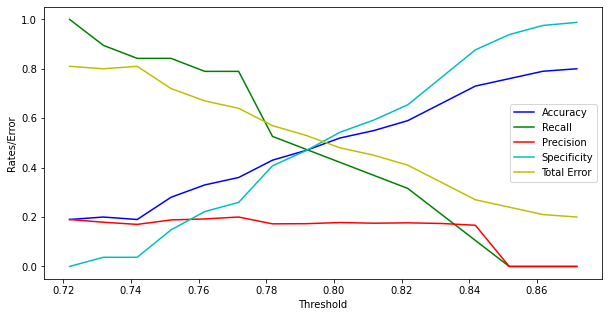

In [11]:
max_value = max(data.angular_distance)
min_value = min(data.angular_distance)

threshold = np.arange(min_value,max_value,0.01)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [22]:
threshold = np.arange(0.74,0.79,0.01)
results = pd.DataFrame(threshold,columns=['threshold'])
results['TP'] = ''
results['TN'] = ''
results['FP'] = ''
results['FN'] = ''

results['specificity'] = ''
results['recall']=''
results['precision']=''
results['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results['threshold'][i]
    data['y_angular'] = ''
    data['cm_angular'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['angular_distance'][j] >= threshold):
            data['y_angular'][j] = 'Y'
        else:
            data['y_angular'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
            data['cm_angular'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
            data['cm_angular'][k] = 'FN'
        else:
            data['cm_angular'][k] = 'TN'
    
    
    tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
    results['TP'][i] = tp
    
    tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
    results['TN'][i] = tn
    
    fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
    results['FP'][i] = fp
    
    fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
    results['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results['precision'][i] = prec
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results['recall'][i] = rec
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results['specificity'][i] = spec

print('---------- ELMo: Angular Distance ----------')
results

---------- ELMo: Angular Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.74,17,3,78,2,0.037037,0.894737,0.178947,0.2
1,0.75,16,10,71,3,0.123457,0.842105,0.183908,0.26
2,0.76,15,18,63,4,0.222222,0.789474,0.192308,0.33
3,0.77,15,21,60,4,0.259259,0.789474,0.2,0.36
4,0.78,10,30,51,9,0.37037,0.526316,0.163934,0.4
5,0.79,9,36,45,10,0.444444,0.473684,0.166667,0.45


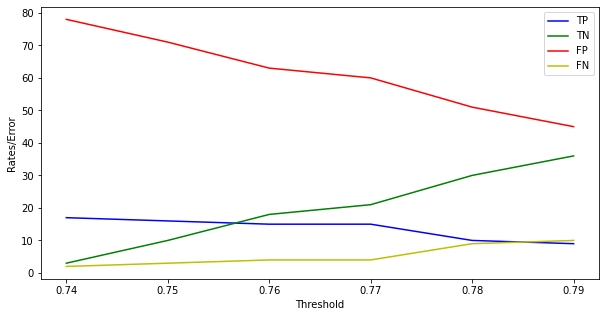

In [23]:
tp_list = results.TP.to_list()
tn_list = results.TN.to_list()
fp_list = results.FP.to_list()
fn_list = results.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.74,0.79,0.01)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [24]:
data['y_angular']=''
for i in range(0,len(data)):
    if data['angular_distance'][i] >= 0.77:
        data['y_angular'][i] = 'Y'
    else:
        data['y_angular'][i] = 'N'
        
data['cm_angular']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_angular'][k] == 'Y'):
        data['cm_angular'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_angular'][k] == 'N'):
        data['cm_angular'][k] = 'FN'
    else:
        data['cm_angular'][k] = 'TN'
        
tp = data.cm_angular.value_counts().TP if 'TP' in data.cm_angular.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_angular.value_counts().TN if 'TN' in data.cm_angular.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_angular.value_counts().FP if 'FP' in data.cm_angular.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_angular.value_counts().FN if 'FN' in data.cm_angular.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 15
true negatives: 21
false positives: 60
false negatives: 4
precision: 0.2
recall: 0.7894736842105263
accuracy: 0.36


#### manhattan

In [15]:
print(max(data.manhattan_distance))
print(min(data.manhattan_distance))

231.2047672501194
103.49958937894553


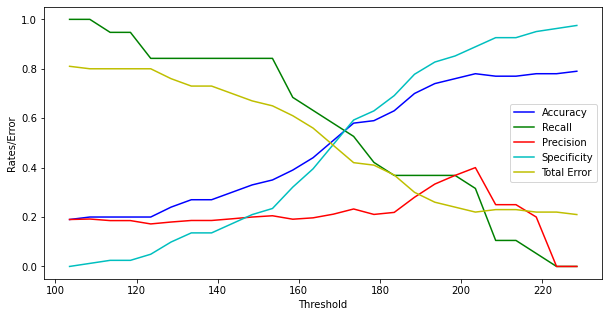

In [16]:
max_value = max(data.manhattan_distance)
min_value = min(data.manhattan_distance)
threshold = np.arange(min_value,max_value,5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [27]:
threshold = np.arange(213,218,1)
results2 = pd.DataFrame(threshold,columns=['threshold'])
results2['TP'] = ''
results2['TN'] = ''
results2['FP'] = ''
results2['FN'] = ''

results2['specificity'] = ''
results2['recall']=''
results2['precision']=''
results2['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results2['threshold'][i]
    data['y_manhattan'] = ''
    data['cm_manhattan'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['manhattan_distance'][j] >= threshold):
            data['y_manhattan'][j] = 'Y'
        else:
            data['y_manhattan'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
            data['cm_manhattan'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
            data['cm_manhattan'][k] = 'FN'
        else:
            data['cm_manhattan'][k] = 'TN'
    
    
    tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
    results2['TP'][i] = tp
    
    tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
    results2['TN'][i] = tn
    
    fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
    results2['FP'][i] = fp
    
    fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
    results2['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results2['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results2['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results2['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results2['specificity'][i] = spec

print('---------- ELMo: Manhattan Distance ----------')    
results2

---------- ELMo: Manhattan Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,213,2,75,6,17,0.925926,0.105263,0.25,0.77
1,214,2,75,6,17,0.925926,0.105263,0.25,0.77
2,215,2,76,5,17,0.938272,0.105263,0.285714,0.78
3,216,2,76,5,17,0.938272,0.105263,0.285714,0.78
4,217,1,76,5,18,0.938272,0.0526316,0.166667,0.77


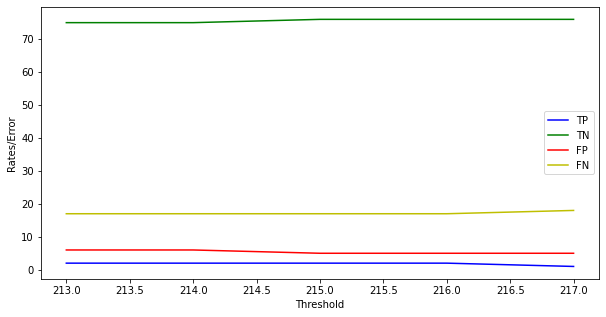

In [28]:
tp_list = results2.TP.to_list()
tn_list = results2.TN.to_list()
fp_list = results2.FP.to_list()
fn_list = results2.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(213,218,1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [29]:
data['y_manhattan']=''
for i in range(0,len(data)):
    if data['manhattan_distance'][i] >= 216:
        data['y_manhattan'][i] = 'Y'
    else:
        data['y_manhattan'][i] = 'N'
        
data['cm_manhattan']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_manhattan'][k] == 'Y'):
        data['cm_manhattan'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_manhattan'][k] == 'N'):
        data['cm_manhattan'][k] = 'FN'
    else:
        data['cm_manhattan'][k] = 'TN'
        
tp = data.cm_manhattan.value_counts().TP if 'TP' in data.cm_manhattan.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_manhattan.value_counts().TN if 'TN' in data.cm_manhattan.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_manhattan.value_counts().FP if 'FP' in data.cm_manhattan.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_manhattan.value_counts().FN if 'FN' in data.cm_manhattan.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 2
true negatives: 76
false positives: 5
false negatives: 17
precision: 0.2857142857142857
specificity: 0.9382716049382716
recall: 0.10526315789473684
accuracy: 0.78


#### euclidean distance

In [20]:
print(max(data.euclidean_distance))
print(min(data.euclidean_distance))

9.661367
4.109021


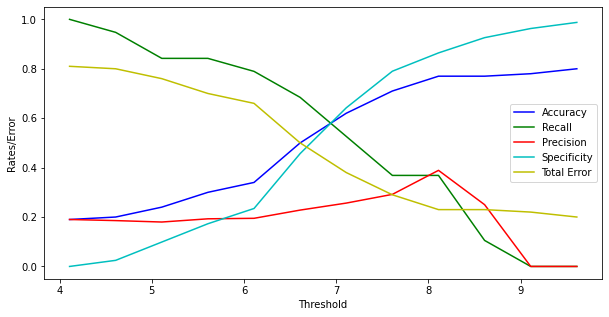

In [21]:
max_value = max(data.euclidean_distance)
min_value = min(data.euclidean_distance)
threshold = np.arange(min_value,max_value,0.5)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [31]:
threshold = np.arange(7.9,8.4,0.1)
results3 = pd.DataFrame(threshold,columns=['threshold'])
results3['TP'] = ''
results3['TN'] = ''
results3['FP'] = ''
results3['FN'] = ''

results3['specificity'] = ''
results3['recall']=''
results3['precision']=''
results3['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results3['threshold'][i]
    data['y_euclid'] = ''
    data['cm_euclid'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['euclidean_distance'][j] >= threshold):
            data['y_euclid'][j] = 'Y'
        else:
            data['y_euclid'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
            data['cm_euclid'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
            data['cm_euclid'][k] = 'FN'
        else:
            data['cm_euclid'][k] = 'TN'
    
    
    tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
    results3['TP'][i] = tp
    
    tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
    results3['TN'][i] = tn
    
    fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
    results3['FP'][i] = fp
    
    fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
    results3['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results3['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results3['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results3['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results3['specificity'][i] = spec

print('---------- ELMo: Euclidean Distance ----------') 
results3

---------- ELMo: Euclidean Distance ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,7.9,7,67,14,12,0.82716,0.368421,0.333333,0.74
1,8.0,7,69,12,12,0.851852,0.368421,0.368421,0.76
2,8.1,7,70,11,12,0.864198,0.368421,0.388889,0.77
3,8.2,7,72,9,12,0.888889,0.368421,0.4375,0.79
4,8.3,5,72,9,14,0.888889,0.263158,0.357143,0.77


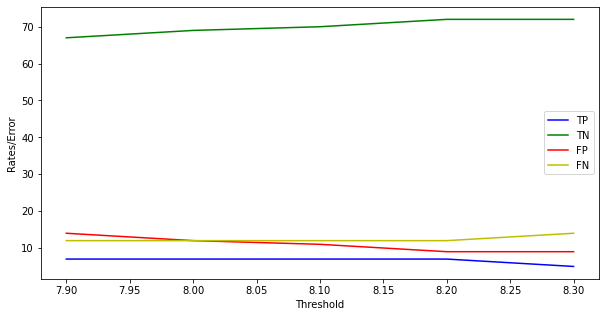

In [32]:
tp_list = results3.TP.to_list()
tn_list = results3.TN.to_list()
fp_list = results3.FP.to_list()
fn_list = results3.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(7.9,8.4,0.1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [33]:
data['y_euclid']=''
for i in range(0,len(data)):
    if data['euclidean_distance'][i] >= 8.2:
        data['y_euclid'][i] = 'Y'
    else:
        data['y_euclid'][i] = 'N'
        
data['cm_euclid']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_euclid'][k] == 'Y'):
        data['cm_euclid'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_euclid'][k] == 'N'):
        data['cm_euclid'][k] = 'FN'
    else:
        data['cm_euclid'][k] = 'TN'
        
tp = data.cm_euclid.value_counts().TP if 'TP' in data.cm_euclid.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_euclid.value_counts().TN if 'TN' in data.cm_euclid.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_euclid.value_counts().FP if 'FP' in data.cm_euclid.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_euclid.value_counts().FN if 'FN' in data.cm_euclid.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 7
true negatives: 72
false positives: 9
false negatives: 12
precision: 0.4375
specificity: 0.8888888888888888
recall: 0.3684210526315789
accuracy: 0.79


#### ts-ss

In [ ]:
print(max(data.tss))
print(min(data.tss))

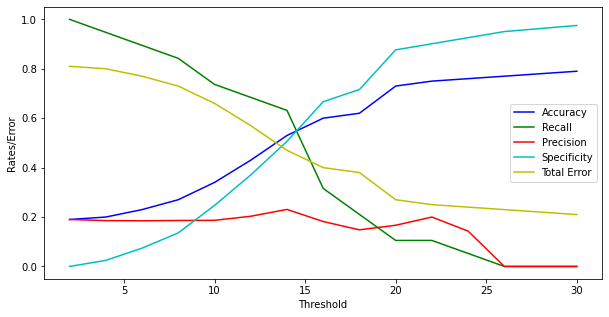

In [34]:
max_value = max(data.tss)
min_value = min(data.tss)
threshold = np.arange(min_value,max_value,2)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [36]:
threshold = np.arange(21,26,1)
results4 = pd.DataFrame(threshold,columns=['threshold'])
results4['TP'] = ''
results4['TN'] = ''
results4['FP'] = ''
results4['FN'] = ''

results4['specificity'] = ''
results4['recall']=''
results4['precision']=''
results4['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results4['threshold'][i]
    data['y_tss'] = ''
    data['cm_tss'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['tss'][j] >= threshold):
            data['y_tss'][j] = 'Y'
        else:
            data['y_tss'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
            data['cm_tss'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
            data['cm_tss'][k] = 'FN'
        else:
            data['cm_tss'][k] = 'TN'
    
    
    tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
    results4['TP'][i] = tp
    
    tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
    results4['TN'][i] = tn
    
    fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
    results4['FP'][i] = fp
    
    fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
    results4['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results4['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results4['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results4['accuracy'][i] = acc 

    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results4['specificity'][i] = spec

print('---------- ELMo: TS-SS ----------') 
results4

---------- ELMo: TS-SS ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,21,2,73,8,17,0.901235,0.105263,0.2,0.75
1,22,2,73,8,17,0.901235,0.105263,0.2,0.75
2,23,2,75,6,17,0.925926,0.105263,0.25,0.77
3,24,1,75,6,18,0.925926,0.0526316,0.142857,0.76
4,25,1,76,5,18,0.938272,0.0526316,0.166667,0.77


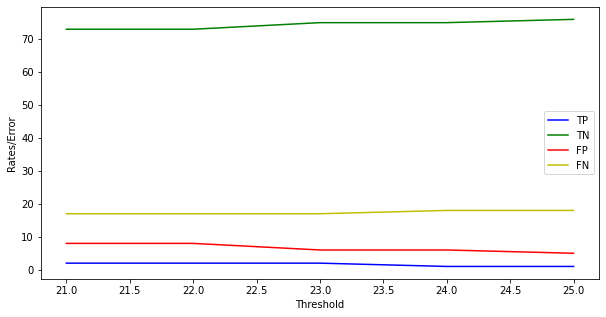

In [43]:
tp_list = results4.TP.to_list()
tn_list = results4.TN.to_list()
fp_list = results4.FP.to_list()
fn_list = results4.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(21,26,1)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [ ]:
data['y_tss']=''
for i in range(0,len(data)):
    if data['tss'][i] >= 23:
        data['y_tss'][i] = 'Y'
    else:
        data['y_tss'][i] = 'N'
        
data['cm_tss']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_tss'][k] == 'Y'):
        data['cm_tss'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_tss'][k] == 'N'):
        data['cm_tss'][k] = 'FN'
    else:
        data['cm_tss'][k] = 'TN'
        
tp = data.cm_tss.value_counts().TP if 'TP' in data.cm_tss.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_tss.value_counts().TN if 'TN' in data.cm_tss.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_tss.value_counts().FP if 'FP' in data.cm_tss.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_tss.value_counts().FN if 'FN' in data.cm_tss.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

#### cosine

In [ ]:
print(max(data.cosine))
print(min(data.cosine))

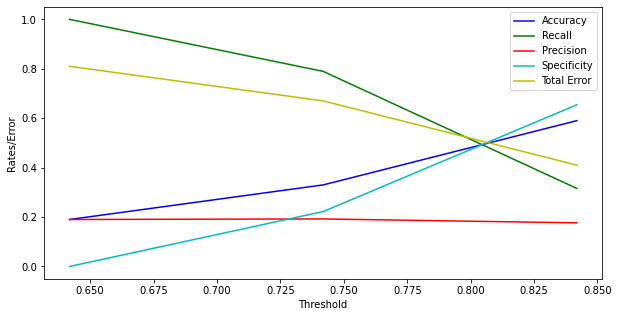

In [38]:
max_value = max(data.cosine)
min_value = min(data.cosine)
threshold = np.arange(min_value,max_value,0.1)

precision=[]
accuracy=[]
recall=[]
specificity=[]

for i in range(0,len(threshold)):
    data['y_pred'] = ''
    data['cm'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold[i]):
            data['y_pred'][j] = 'Y'
        else:
            data['y_pred'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_pred'][k] == 'Y'):
            data['cm'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_pred'][k] == 'N'):
            data['cm'][k] = 'FN'
        else:
            data['cm'][k] = 'TN'
    
    
    tp = data.cm.value_counts().TP if 'TP' in data.cm.value_counts() is not None else 0
    tn = data.cm.value_counts().TN if 'TN' in data.cm.value_counts() is not None else 0
    fp = data.cm.value_counts().FP if 'FP' in data.cm.value_counts() is not None else 0
    fn = data.cm.value_counts().FN if 'FN' in data.cm.value_counts() is not None else 0

    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    precision.append(prec)
    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    recall.append(rec)
    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    accuracy.append(acc)
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    specificity.append(spec)

plt.figure(figsize=(10,5))

plt.plot(threshold, accuracy, color = 'b', label = 'Accuracy')
plt.plot(threshold, recall, color = 'g', label = 'Recall')
plt.plot(threshold, precision, color = 'r', label = 'Precision')
plt.plot(threshold, specificity, color = 'c', label = 'Specificity')
plt.plot(threshold, [1-x for x in accuracy], color = 'y', label = 'Total Error')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [40]:
threshold = np.arange(0.73,0.78,0.01)
results5 = pd.DataFrame(threshold,columns=['threshold'])
results5['TP'] = ''
results5['TN'] = ''
results5['FP'] = ''
results5['FN'] = ''

results5['specificity'] = ''
results5['recall']=''
results5['precision']=''
results5['accuracy']=''

for i in range(0,len(threshold)):
    threshold = results5['threshold'][i]
    data['y_cosine'] = ''
    data['cm_cosine'] = ''
    
    for j in range(0,len(data)): # generate predicted values
        if (data['cosine'][j] >= threshold):
            data['y_cosine'][j] = 'Y'
        else:
            data['y_cosine'][j] = 'N'
            
    
    for k in range(0,len(data)): # determine confusion matrix
        if (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'TP'
        elif (data['truth'][k] == 'N') and (data['y_cosine'][k] == 'Y'):
            data['cm_cosine'][k] = 'FP'
        elif (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'N'):
            data['cm_cosine'][k] = 'FN'
        else:
            data['cm_cosine'][k] = 'TN'
    
    
    tp = data.cm_cosine.value_counts().TP if 'TP' in data.cm_cosine.value_counts() is not None else 0
    results5['TP'][i] = tp
    
    tn = data.cm_cosine.value_counts().TN if 'TN' in data.cm_cosine.value_counts() is not None else 0
    results5['TN'][i] = tn
    
    fp = data.cm_cosine.value_counts().FP if 'FP' in data.cm_cosine.value_counts() is not None else 0
    results5['FP'][i] = fp
    
    fn = data.cm_cosine.value_counts().FN if 'FN' in data.cm_cosine.value_counts() is not None else 0
    results5['FN'][i] = fn
    
    prec = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
    results5['precision'][i] = prec

    
    rec = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
    results5['recall'][i] = rec

    
    acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
    results5['accuracy'][i] = acc 
    
    spec = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
    results5['specificity'][i] = spec

print('---------- ELMo: Cosine Similiarity ----------')    
results5

---------- ELMo: Cosine Similiarity ----------


,threshold,TP,TN,FP,FN,specificity,recall,precision,accuracy
0,0.73,15,18,63,4,0.222222,0.789474,0.192308,0.33
1,0.74,15,18,63,4,0.222222,0.789474,0.192308,0.33
2,0.75,15,21,60,4,0.259259,0.789474,0.2,0.36
3,0.76,13,25,56,6,0.308642,0.684211,0.188406,0.38
4,0.77,10,30,51,9,0.37037,0.526316,0.163934,0.4
5,0.78,10,34,47,9,0.419753,0.526316,0.175439,0.44


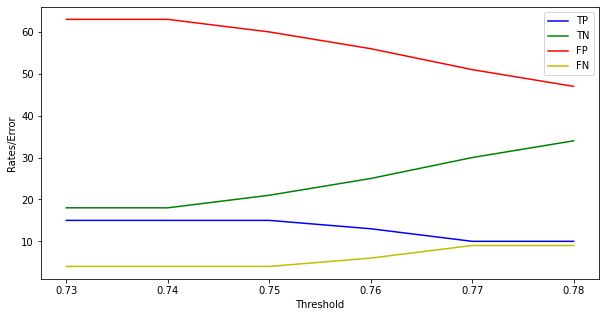

In [41]:
tp_list = results5.TP.to_list()
tn_list = results5.TN.to_list()
fp_list = results5.FP.to_list()
fn_list = results5.FN.to_list()

plt.figure(figsize=(10,5))

threshold = np.arange(0.73,0.78,0.01)

plt.plot(threshold,tp_list, color = 'b', label = 'TP')
plt.plot(threshold,tn_list, color = 'g', label = 'TN')
plt.plot(threshold,fp_list, color = 'r', label = 'FP')
plt.plot(threshold,fn_list, color = 'y', label = 'FN')
plt.xlabel("Threshold")
plt.ylabel("Rates/Error")
plt.legend()
plt.show()

In [42]:
data['y_cosine']=''
for i in range(0,len(data)):
    if data['cosine'][i] >= 0.75:
        data['y_cosine'][i] = 'Y'
    else:
        data['y_cosine'][i] = 'N'
        
data['cm_cosine']=''
for k in range(0,len(data)):
    if (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'Y'):
        data['cm_cosine'][k] = 'TP'
    elif (data['truth'][k] == 'N') and (data['y_cosine'][k] == 'Y'):
        data['cm_cosine'][k] = 'FP'
    elif (data['truth'][k] == 'Y') and (data['y_cosine'][k] == 'N'):
        data['cm_cosine'][k] = 'FN'
    else:
        data['cm_cosine'][k] = 'TN'

tp = data.cm_cosine.value_counts().TP if 'TP' in data.cm_cosine.value_counts() is not None else 0
print('true positives:',tp)
tn = data.cm_cosine.value_counts().TN if 'TN' in data.cm_cosine.value_counts() is not None else 0
print('true negatives:',tn)
fp = data.cm_cosine.value_counts().FP if 'FP' in data.cm_cosine.value_counts() is not None else 0
print('false positives:',fp)
fn = data.cm_cosine.value_counts().FN if 'FN' in data.cm_cosine.value_counts() is not None else 0
print('false negatives:',fn)

precision = (tp/(tp+fp)) if (tp+fp) is not 0 else 0
print('precision:',precision)

specificity = (tn / (tn + fp)) if (tn + fp) is not 0 else 0
print('specificity:',specificity)
    
recall = (tp/(tp+fn)) if (tp+fn) is not 0 else 0
print('recall:',recall)   

acc = ((tp+tn)/(tp+tn+fp+fn)) if (tp+tn+fp+fn) is not 0 else 0
print('accuracy:',acc)

true positives: 15
true negatives: 21
false positives: 60
false negatives: 4
precision: 0.2
specificity: 0.25925925925925924
recall: 0.7894736842105263
accuracy: 0.36


In [ ]:
data.drop(['y_pred', 'cm'], axis=1, inplace=True)
data.to_excel('elmo.xlsx',index=False)